In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import  pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

In [3]:
!pip install ipython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
from IPython.core.pylabtools import figsize

In [5]:
from google.colab import files
uploaded = files.upload() 
df = pd.read_csv('austin_cleaned.csv',index_col='Date',parse_dates=False,on_bad_lines='skip')

Saving austin_cleaned.csv to austin_cleaned.csv


In [6]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM

In [7]:
tf.random.set_seed(1234)

In [8]:
df.describe()

,TempHighF,TempAvgF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,SeaLevelPressureHighInches,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches,Events
count,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,1256.000000,0.0
mean,80.844745,70.554936,59.755573,61.187898,56.321656,50.667197,87.464968,66.072452,44.174363,30.113471,30.024427,29.933670,9.995223,9.257962,7.108280,13.111465,5.014331,21.214968,0.072111,NaN
std,14.839989,14.119304,14.270577,13.655279,14.942654,16.229944,11.063686,12.247657,16.518849,0.180627,0.172920,0.172944,0.089136,1.373169,3.491968,3.286141,2.084613,5.764568,0.282235,NaN
min,32.000000,29.000000,19.000000,13.000000,8.000000,2.000000,37.000000,27.000000,10.000000,29.630000,29.550000,29.410000,8.000000,2.000000,0.000000,6.000000,1.000000,9.000000,0.000000,NaN
25%,72.000000,61.000000,49.000000,52.000000,46.000000,38.000000,84.000000,59.000000,32.000000,29.990000,29.920000,29.830000,10.000000,9.000000,4.000000,10.000000,3.000000,17.000000,0.000000,NaN
50%,83.000000,73.000000,62.000000,66.000000,61.000000,55.500000,90.000000,67.000000,43.000000,30.080000,30.000000,29.910000,10.000000,10.000000,9.000000,13.000000,5.000000,21.000000,0.000000,NaN
75%,92.000000,83.000000,73.000000,73.000000,69.000000,65.000000,94.000000,74.000000,54.000000,30.210000,30.110000,30.020000,10.000000,10.000000,10.000000,15.000000,6.000000,25.000000,0.001000,NaN
max,107.000000,93.000000,81.000000,80.000000,76.000000,75.000000,100.000000,97.000000,93.000000,30.830000,30.740000,30.610000,10.000000,10.000000,10.000000,26.000000,12.000000,57.000000,4.790000,NaN


In [9]:
len(df)

1256

In [10]:
df=df.drop(['Events'], axis = 1)

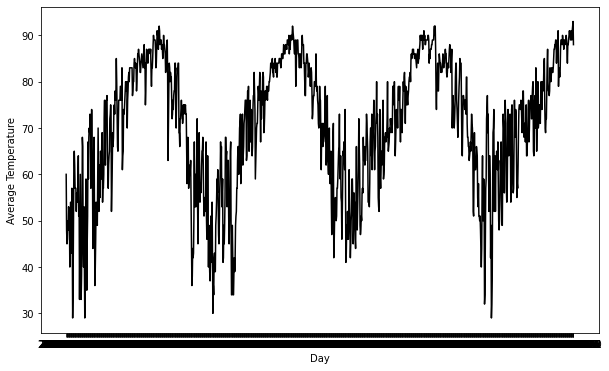

In [11]:
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label) 
    plt.ylabel(y_label)
timeseries(df.index, df['TempAvgF'],'Day','Average Temperature')

In [12]:
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size],df.iloc[train_size:]

In [13]:
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

Dimension of train data:  (1004, 19)
Dimension of test data:  (252, 19)


In [14]:
X_train = train_dataset.drop('TempAvgF', axis = 1)
y_train = train_dataset.loc[:,['TempAvgF']]

X_test = test_dataset.drop('TempAvgF', axis = 1)
y_test = test_dataset.loc[:,['TempAvgF']]

In [15]:
scaler_x = MinMaxScaler(feature_range = (0,1))
scaler_y = MinMaxScaler(feature_range = (0,1))
input_scaler = scaler_x.fit(X_train)
output_scaler = scaler_y.fit(y_train)
train_y_norm = output_scaler.transform(y_train)
train_x_norm = input_scaler.transform(X_train)
test_y_norm = output_scaler.transform(y_test)
test_x_norm = input_scaler.transform(X_test)

In [16]:
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 1
X_test, y_test = create_dataset(test_x_norm, test_y_norm,TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm,TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)

X_train.shape:  (251, 1, 18)
y_train.shape:  (1003, 1)
X_test.shape:  (251, 1, 18)
y_test.shape:  (1003, 1)


In [17]:
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
model_lstm = create_model(64, LSTM)

In [18]:
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',patience = 10)
    history = model.fit(X_train, y_train, epochs = 100,validation_split = 0.2, batch_size = 32,shuffle = False, callbacks = [early_stop])
    return history
history_lstm = fit_model(model_lstm)

Epoch 1/100
26/26 [==============================] - 12s 100ms/step - loss: 0.2402 - val_loss: 0.0458
Epoch 2/100
26/26 [==============================] - 0s 7ms/step - loss: 0.0439 - val_loss: 0.0272
Epoch 3/100
26/26 [==============================] - 0s 7ms/step - loss: 0.0400 - val_loss: 0.0144
Epoch 4/100
26/26 [==============================] - 0s 7ms/step - loss: 0.0319 - val_loss: 0.0099
Epoch 5/100
26/26 [==============================] - 0s 7ms/step - loss: 0.0295 - val_loss: 0.0069
Epoch 6/100
26/26 [==============================] - 0s 7ms/step - loss: 0.0225 - val_loss: 0.0052
Epoch 7/100
26/26 [==============================] - 0s 7ms/step - loss: 0.0187 - val_loss: 0.0037
Epoch 8/100
26/26 [==============================] - 0s 7ms/step - loss: 0.0151 - val_loss: 0.0037
Epoch 9/100
26/26 [==============================] - 0s 7ms/step - loss: 0.0138 - val_loss: 0.0043
Epoch 10/100
26/26 [==============================] - 0s 7ms/step - loss: 0.0139 - val_loss: 0.0034
Epoch 

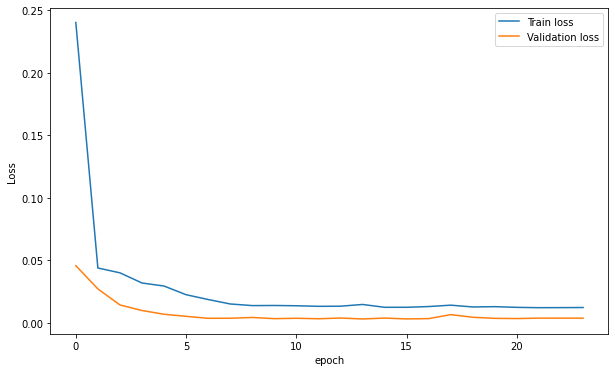

In [19]:
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plot_loss (history_lstm)

In [20]:
y_test = scaler_y.inverse_transform(y_test)
y_train = scaler_y.inverse_transform(y_train)

In [21]:
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler_y.inverse_transform(prediction)
    return prediction
prediction_lstm = prediction(model_lstm)

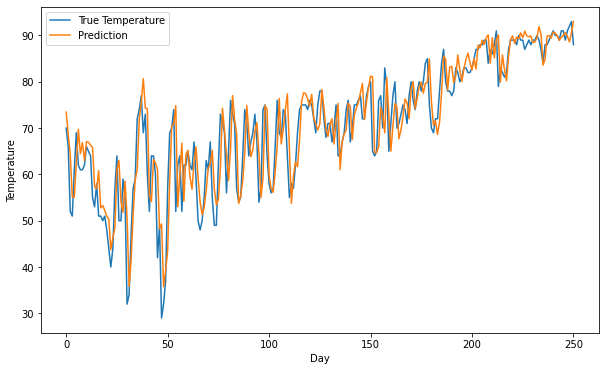

In [22]:
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Temperature')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Day')
    plt.ylabel('Temperature')
plot_future(prediction_lstm, y_test)

In [23]:
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))

In [24]:
evaluate_prediction(prediction_lstm, y_test, 'LSTM')

LSTM:
Mean Absolute Error: 4.1405
Root Mean Square Error: 5.8098


In [32]:
!pip install gradio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
def create_datasetf (X, time_steps = 1):
    Xs = []
    for i in range(1):
        v = X[i:i+time_steps, :]
        Xs.append(v)
    return np.array(Xs)

In [34]:
def predictionn(TempHighF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,SeaLevelPressureHighInches,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches):
    arr = np.array([TempHighF,TempLowF,DewPointHighF,DewPointAvgF,DewPointLowF,HumidityHighPercent,HumidityAvgPercent,HumidityLowPercent,SeaLevelPressureHighInches,SeaLevelPressureAvgInches,SeaLevelPressureLowInches,VisibilityHighMiles,VisibilityAvgMiles,VisibilityLowMiles,WindHighMPH,WindAvgMPH,WindGustMPH,PrecipitationSumInches])
    arr=arr.reshape(1,-1)
    arr = input_scaler.transform(arr)
    TIME_STEPS = 1
    arr_test = create_datasetf(arr, TIME_STEPS)
    predictionn = model_lstm.predict(arr_test)
    predictionn = scaler_y.inverse_transform(predictionn)
    return predictionn

In [36]:
import gradio as gr

In [ ]:

demo = gr.Interface(
    fn=predictionn,
    inputs=["number", "number", "number","number","number","number","number","number","number","number","number","number","number","number","number","number","number","number"],
    outputs=["number"],
    title="Austin LSTM Temperature Prediction"
)
demo.launch(debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://35246.gradio.app

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature na